In [ ]:
!pip install filterpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.0/178.0 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for filterpy: filename=filterpy-1.4.5-py3-none-any.whl size=110458 sha256=e18e972784de16051797010b5aa1f1939aa6c85653d8f7d43eec351dc7d500a6
  Stored in directory: /root/.cache/pip/wheels/0f/0c/ea/218f266af4ad626897562199fbbcba521b8497303200186102
Successfully built filterpy


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from filterpy.kalman import ExtendedKalmanFilter
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, MultiHeadAttention, LayerNormalization,LSTM,Attention, Add, LayerNormalization, Conv1D, Bidirectional, GRU
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau

import seaborn as sns

sns.set()

#**KFFLSTM 1D**

In [ ]:
'''
# Non-linear state transition function
def f(x, k):
    return x / 2 + 25 * x / (1 + x**2) + 8 * np.cos(1.2 * k)

#observation function
def h(x):
    return x**2 / 2

# Process and measurement noise
def generate_noise(size, noise_cov):
    return np.random.normal(0, np.sqrt(noise_cov), size)

# Simulation parameters
np.random.seed(0)
num_steps = 100
process_noise_cov = 4.0
measurement_noise_cov = 7.0

# Generate true states and measurements
x_true = np.zeros(num_steps)
z = np.zeros(num_steps)
x_true[0] = np.random.randn()
for k in range(1, num_steps):
    x_true[k] = f(x_true[k-1], k) + generate_noise(1, process_noise_cov)
    z[k] = h(x_true[k]) + generate_noise(1, measurement_noise_cov)

# Prepare training data for LSTM models
def create_lstm_dataset(x, y, time_steps=5):
    Xs, ys = [], []
    for i in range(len(x) - time_steps):
        Xs.append(x[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 10
X, y = create_lstm_dataset(x_true, x_true, time_steps)
X_measure, y_measure = create_lstm_dataset(z, z, time_steps)

# Calculate residuals for Q and R training
residuals_x = x_true[1:] - np.array([f(x_true[i], i+1) for i in range(num_steps-1)])
residuals_z = z[1:] - np.array([h(x_true[i]) for i in range(1, num_steps)])

# Prepare training data for Q and R
X_q, y_q = create_lstm_dataset(residuals_x, residuals_x, time_steps)
X_r, y_r = create_lstm_dataset(residuals_z, residuals_z, time_steps)

# Define LSTM models
def create_lstm_model_a(input_shape):
    model = Sequential()
    model.add(LSTM(1024, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.8))
    model.add(LSTM(1024, activation='relu', return_sequences=True))
    model.add(Dropout(0.8))
    model.add(LSTM(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1024, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

def create_lstm_model_qr(input_shape):
    model = Sequential()
    model.add(LSTM(256 if input_shape[0] == 1 else 128, activation='relu', input_shape=input_shape))
    model.add(Dropout(0.8))
    model.add(Dense(2))
    model.compile(optimizer='adam', loss='mse')
    return model

# Create and train LSTM models
lstm_a = create_lstm_model_a((time_steps, 1))
lstm_q = create_lstm_model_qr((time_steps, 1))
lstm_r = create_lstm_model_qr((time_steps, 1))

lstm_a.fit(X, y, epochs=4, verbose=1)
lstm_q.fit(X_q, y_q, epochs=4, verbose=1)
lstm_r.fit(X_r, y_r, epochs=4, verbose=1)

# Integrate LSTM models with Kalman Filter
kf = KalmanFilter(dim_x=1, dim_z=1)
kf.x = np.array([0.0])
kf.P *= 10

ekf_states = np.zeros(num_steps)
x_hat = np.zeros((num_steps, 1))
x_hat[0] = np.random.randn()

for k in range(1, num_steps):
    if k >= time_steps:
        # LSTM-A prediction
        if k < time_steps:
            x_input = np.zeros((1, time_steps, 1))
            x_input[0, -k:] = x_hat[:k].reshape(-1, 1)
        else:
            x_input = x_hat[k-time_steps:k].reshape(1, time_steps, 1)

        x_hat_prime = lstm_a.predict(x_input)

        # LSTM-Q prediction
        q_input = residuals_x[k-time_steps:k].reshape(1, time_steps, 1)
        q_hat = lstm_q.predict(q_input)
        kf.Q = np.array([[q_hat[0, 0]]])

        # LSTM-R prediction
        r_input = residuals_z[k-time_steps:k].reshape(1, time_steps, 1)
        r_hat = lstm_r.predict(r_input)
        kf.R = np.array([[r_hat[0, 0]]])

        # Kalman filter prediction and update
        kf.predict()
        kf.update(z[k])
        ekf_states[k] = kf.x

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(x_true, label='True State')
plt.plot(z, label='Measurements')
plt.plot(ekf_states, label='EKF Estimate', linestyle='dashed')
plt.xlabel('Time step')
plt.ylabel('Value')
plt.title('LSTM-KF State Estimation')
plt.legend()
plt.show()
'''

"\n# Non-linear state transition function\ndef f(x, k):\n    return x / 2 + 25 * x / (1 + x**2) + 8 * np.cos(1.2 * k)\n\n#observation function\ndef h(x):\n    return x**2 / 2\n\n# Process and measurement noise\ndef generate_noise(size, noise_cov):\n    return np.random.normal(0, np.sqrt(noise_cov), size)\n\n# Simulation parameters\nnp.random.seed(0)\nnum_steps = 100\nprocess_noise_cov = 4.0\nmeasurement_noise_cov = 7.0\n\n# Generate true states and measurements\nx_true = np.zeros(num_steps)\nz = np.zeros(num_steps)\nx_true[0] = np.random.randn()\nfor k in range(1, num_steps):\n    x_true[k] = f(x_true[k-1], k) + generate_noise(1, process_noise_cov)\n    z[k] = h(x_true[k]) + generate_noise(1, measurement_noise_cov)\n\n# Prepare training data for LSTM models\ndef create_lstm_dataset(x, y, time_steps=5):\n    Xs, ys = [], []\n    for i in range(len(x) - time_steps):\n        Xs.append(x[i:(i + time_steps)])\n        ys.append(y[i + time_steps])\n    return np.array(Xs), np.array(ys)\n\nt

#**Attension kalman filter 2D**


In [ ]:
np.random.seed(0)
STATE_DIMENSION = 2
MEASUREMENTS_DIMENSION = 2
PROCESS_NOISE_VAR = 10
OBSERVERD_NOISE_VAR = 1
INITIAL_STATE_VAR = 1
TIME_STEPS = 10000
x0 = np.random.normal(0,1,size=(2,1))*4

#state estimation

In [ ]:
#state function
def f(x, k):
    return x / 2 + 25 * x / (1 + x**2) + 8 * np.cos(1.2 * k)

states = np.zeros((2,TIME_STEPS))
states[:,0] = x0.ravel()
for step in range(1,TIME_STEPS) :
    states[:,step] = f(states[:,step-1],step)
states[1,:] = states[1,:][::-1]
noisy_states = states + np.random.normal(0,PROCESS_NOISE_VAR,size=states.shape)

Text(0, 0.5, 'state')

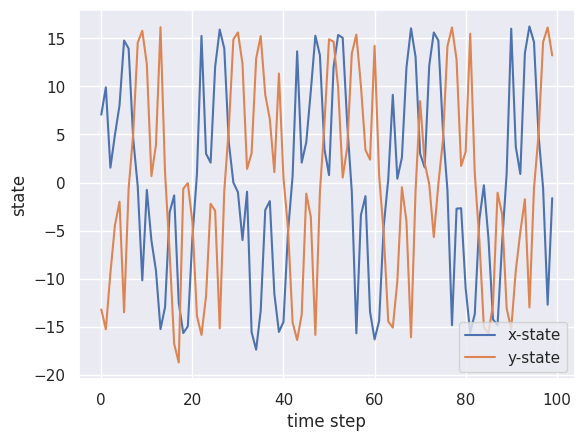

In [ ]:
plt.plot(np.arange(100),states[0,:100],label = 'x-state')
plt.plot(np.arange(100),states[1,:100],label = 'y-state')
plt.legend()
plt.xlabel('time step')
plt.ylabel('state')

In [ ]:
window_size = 1  # Number of steps to consider
states_prev = np.array([states[:, i-window_size:i].T for i in range(window_size, TIME_STEPS)])
states_next = states[:, window_size:].T

input_shape = (window_size, 2)  # Assuming 2-dimensional state vectors

In [ ]:
input_shape = (window_size, 2)  # Assuming 2-dimensional state vectors

In [ ]:
import numpy as np

def create_one_step_sequences(data):
    sequences = []
    targets = []
    for i in range(len(data) - 1):
        sequences.append(data[i:i+1])  # Single previous state
        targets.append(data[i+1])      # Next state
    return np.array(sequences), np.array(targets)


sequences, targets = create_one_step_sequences(states.T)

In [ ]:
sequences.shape

(9999, 1, 2)

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch
import math
from torch.autograd import Variable

class TransformerBlock(nn.Module):
    """
    Bidirectional Encoder = Transformer (self-attention)
    Transformer = MultiHead_Attention + Feed_Forward with sublayer connection
    """

    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        """
        :param hidden: hidden size of transformer
        :param attn_heads: head sizes of multi-head attention
        :param feed_forward_hidden: feed_forward_hidden, usually 4*hidden_size
        :param dropout: dropout rate
        """

        super().__init__()
        self.hidden = hidden
        self.input_proj = nn.Linear(2, hidden)  # Project input to hidden size
        self.attention = MultiHeadedAttention(h=attn_heads, d_model=hidden)
        self.feed_forward = PositionwiseFeedForward(d_model=hidden, d_ff=feed_forward_hidden, dropout=dropout)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        self.position = PositionalEmbedding(self.hidden, x.size()[1])

        x = self.input_proj(x)  # Project input to hidden size
        x = x + self.position(x)
        x = self.input_sublayer(x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)


class PositionalEmbedding(nn.Module):

    def __init__(self, d_model, max_len=512):
        super().__init__()

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model).float()
        pe.require_grad = False

        position = torch.arange(0, max_len).float().unsqueeze(1)
        div_term = (torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model)).exp()

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[:, :x.size(1)]


class MultiHeadedAttention(nn.Module):
    """
    Take in model size and number of heads.
    """

    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        # 2) Apply attention on all the projected vectors in batch.
        x, attn = self.attention(query, key, value, mask=mask, dropout=self.dropout)

        # 3) "Concat" using a view and apply a final linear.
        x = x.transpose(1, 2).contiguous().view(batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)



class Attention(nn.Module):
    """
    Compute 'Scaled Dot Product Attention
    """

    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) \
                 / math.sqrt(query.size(-1))

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)

        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn

class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.dropout(self.activation(self.w_1(x))))

class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))

class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

class GELU(nn.Module):
    """
    Paper Section 3.4, last paragraph notice that BERT used the GELU instead of RELU
    """

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))

def train(sequences, targets, hidden, attn_heads=2, dropout=0.1, epochtime=1000):
    feature_dim = sequences.shape[2]

    net = TransformerBlock(hidden, attn_heads, hidden * 4, dropout)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    loss_list = []

    sequences = torch.Tensor(sequences)
    targets = torch.Tensor(targets)

    for e in range(epochtime):
        out = net(sequences, mask=None)
        loss = criterion(out[:, -1, :], targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())
        if (e + 1) % 50 == 0:
            print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

    net = net.eval()
    var_data = Variable(sequences)
    pred_test = net(var_data, mask=None)
    pred_test = pred_test[:, -1, :].data.numpy()
    return net,pred_test, loss_list

# Prepare data
def create_one_step_sequences(data):
    sequences = []
    targets = []
    for i in range(len(data) - 1):
        sequences.append(data[i:i+1])  # Single previous state
        targets.append(data[i+1])      # Next state
    return np.array(sequences), np.array(targets)


hidden = 2
net_a,pred_state, loss_list = train(sequences, targets, hidden)
print("Predictions:", pred_test)

def predict_next_state(model, sequence):
    sequence = torch.Tensor(sequence).unsqueeze(0)  # Add batch dimension
    model = model.eval()
    with torch.no_grad():
        prediction = model(sequence, mask=None)
    return prediction[:, -1, :].data.numpy()



Epoch: 50, Loss: 75.63853
Epoch: 100, Loss: 72.76011
Epoch: 150, Loss: 67.26212
Epoch: 200, Loss: 60.05049
Epoch: 250, Loss: 57.13898
Epoch: 300, Loss: 56.04277
Epoch: 350, Loss: 55.72730
Epoch: 400, Loss: 55.11864
Epoch: 450, Loss: 55.51517
Epoch: 500, Loss: 55.25010
Epoch: 550, Loss: 55.06541
Epoch: 600, Loss: 55.24916
Epoch: 650, Loss: 55.36850
Epoch: 700, Loss: 54.06903
Epoch: 750, Loss: 54.54056
Epoch: 800, Loss: 54.95914
Epoch: 850, Loss: 55.06955
Epoch: 900, Loss: 56.08565
Epoch: 950, Loss: 55.45231
Epoch: 1000, Loss: 54.98960
Predictions: [[ 5.241808  -8.058622 ]
 [ 6.5441446 -8.683756 ]
 [ 2.7066875 -6.963458 ]
 ...
 [-4.227235   1.7874303]
 [-6.626943   1.8503423]
 [-8.808341   7.2371063]]


In [ ]:
states_next.shape

(9999, 2)

#process noise estimation

In [ ]:
process_residuals = states_next - pred_state

In [ ]:
process_residuals.shape

(9999, 2)

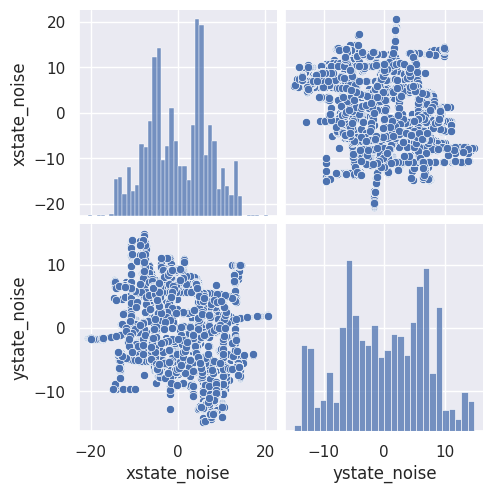

In [ ]:
import pandas as pd
sns.pairplot(pd.DataFrame(process_residuals,columns=['xstate_noise','ystate_noise']))

In [ ]:
pred_state_train = pred_test.reshape((-1,1,2))

In [ ]:
hidden = 2
net_q,pred_q, _ = train(pred_state_train, process_residuals, hidden)

Epoch: 50, Loss: 51.94457
Epoch: 100, Loss: 51.12424
Epoch: 150, Loss: 50.09575
Epoch: 200, Loss: 50.32003
Epoch: 250, Loss: 50.48661
Epoch: 300, Loss: 49.87026
Epoch: 350, Loss: 49.62013
Epoch: 400, Loss: 49.37731
Epoch: 450, Loss: 49.21694
Epoch: 500, Loss: 49.06789
Epoch: 550, Loss: 49.21080
Epoch: 600, Loss: 48.97201
Epoch: 650, Loss: 48.70700
Epoch: 700, Loss: 48.90327
Epoch: 750, Loss: 50.39797
Epoch: 800, Loss: 49.77412
Epoch: 850, Loss: 51.35025
Epoch: 900, Loss: 51.92600
Epoch: 950, Loss: 51.62287
Epoch: 1000, Loss: 50.99364


#measurement noise estimation

In [ ]:
#measurement function
def h(x):
    return x**2 / 2

measurements = np.zeros((2,TIME_STEPS-1))
for step in range(0,TIME_STEPS-1) :
    measurements[:,step] = h(states[:,step])
noisy_measurements = measurements + np.random.normal(0,OBSERVERD_NOISE_VAR ,size=measurements.shape)

In [ ]:
measurements_residuals =  (measurements - noisy_measurements).T

In [ ]:
net_r,pred_r, _ = train(pred_state_train, measurements_residuals, hidden)

Epoch: 50, Loss: 2.15969
Epoch: 100, Loss: 1.32521
Epoch: 150, Loss: 1.12603
Epoch: 200, Loss: 1.05291
Epoch: 250, Loss: 1.04951
Epoch: 300, Loss: 1.04033
Epoch: 350, Loss: 1.03325
Epoch: 400, Loss: 1.02375
Epoch: 450, Loss: 1.02149
Epoch: 500, Loss: 1.01894
Epoch: 550, Loss: 1.01456
Epoch: 600, Loss: 1.01132
Epoch: 650, Loss: 1.01353
Epoch: 700, Loss: 1.00927
Epoch: 750, Loss: 1.00752
Epoch: 800, Loss: 1.00831
Epoch: 850, Loss: 1.00670
Epoch: 900, Loss: 1.00713
Epoch: 950, Loss: 1.00555
Epoch: 1000, Loss: 1.00329


In [ ]:
predict_next_state(net_a,states[:,0]).shape

(1, 2)

In [ ]:
from filterpy.kalman import KalmanFilter

def kalman_filter_with_transformer(observation_seq, initial_state, initial_covariance,reg_factor=1e-4):
    state_dim = initial_state.shape[0]
    n_timesteps = len(observation_seq)

    # Initialize state and covariance matrices
    x_t = initial_state
    P_t = initial_covariance

    state_estimates = np.zeros((n_timesteps, state_dim))
    covariance_estimates = np.zeros((n_timesteps, state_dim, state_dim))

    for t in range(100):
        y_t = observation_seq[t].reshape(1, -1)  # Reshape to match model input

        #print(x_t.reshape(1,1, -1).shape)
        x_t_prime = predict_next_state(net_a,x_t.reshape(1,-1))
        Q_t = np.diag(predict_next_state(net_q,x_t.reshape(1,-1)))
        R_t = np.diag(predict_next_state(net_a,x_t.reshape(1,-1)))

        # Prediction step
        P_t_prime = P_t + Q_t

        # Kalman gain
        H_t = np.eye(state_dim)  # Assuming direct measurement
        # Add regularization to avoid singular matrix
        innovation_covariance = H_t @ P_t_prime @ H_t.T + R_t + reg_factor * np.eye(state_dim)
        K_t = P_t_prime @ H_t.T @ np.linalg.inv(innovation_covariance)

        # Update step
        x_t_prime = x_t_prime.reshape(-1,1)
        y_t = y_t.T
        x_t = x_t_prime + K_t @ (y_t - x_t_prime)
        P_t = (np.eye(state_dim) - K_t @ H_t) @ P_t_prime

        # Save estimates
        state_estimates[t] = x_t.ravel()
        covariance_estimates[t] = P_t

    return state_estimates, covariance_estimates

# Define initial state and covariance
initial_state = x0
initial_covariance = np.eye(2)

# Example observation sequence
observation_seq = noisy_measurements.T

# Run the Kalman filter with LSTM integration
state_estimates, covariance_estimates = kalman_filter_with_transformer(observation_seq, initial_state, initial_covariance)

In [ ]:
true_state = states[:,:100].T
state_estimates_100 = state_estimates[:100,:]

In [ ]:
print('true_states shape :',true_state.shape)
print('state_estimates :',state_estimates_100.shape)

true_states shape : (100, 2)
state_estimates : (100, 2)


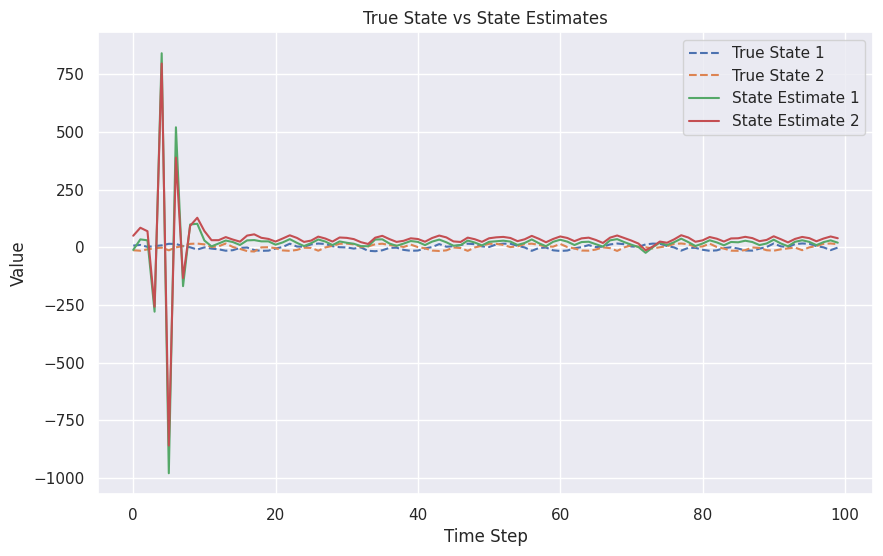

In [ ]:
import matplotlib.pyplot as plt

# Assuming true_state and state_estimates_100 are numpy arrays
# true_state.shape = (100, num_features)
# state_estimates_100.shape = (100, num_features)

num_features = true_state.shape[1]  # Assuming true_state and state_estimates_100 have same number of features

plt.figure(figsize=(10, 6))

# Plot true state
for i in range(num_features):
    plt.plot(true_state[:, i], label=f'True State {i+1}', linestyle='--')

# Plot state estimates
for i in range(num_features):
    plt.plot(state_estimates_100[:, i], label=f'State Estimate {i+1}')

plt.title('True State vs State Estimates')
plt.xlabel('Time Step')
plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()


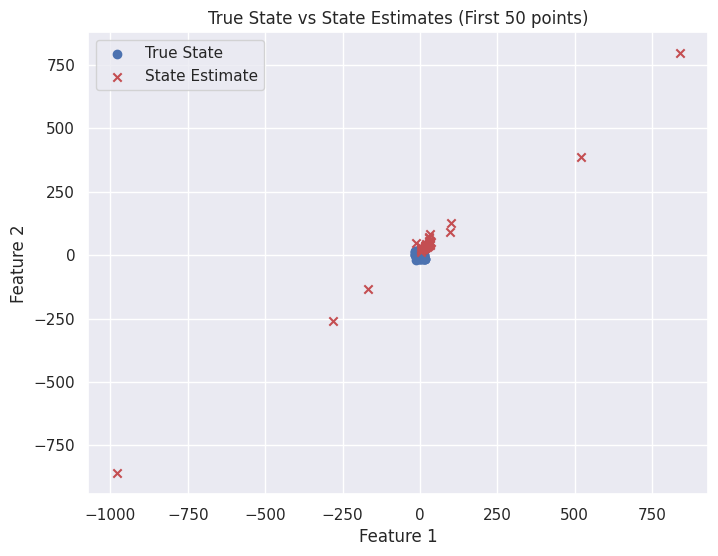

In [ ]:
import matplotlib.pyplot as plt

# Assuming true_state and state_estimates_100 are numpy arrays
# true_state.shape = (100, num_features)
# state_estimates_100.shape = (100, num_features)

plt.figure(figsize=(8, 6))

# Plot true state
plt.scatter(true_state[:50, 0], true_state[:50, 1], label='True State', marker='o', color='b')

# Plot state estimates
plt.scatter(state_estimates_100[:50, 0], state_estimates_100[:50, 1], label='State Estimate', marker='x', color='r')

plt.title('True State vs State Estimates (First 50 points)')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np

# Assuming true_state and state_estimates_100 are numpy arrays
# true_state.shape = (100, num_features)
# state_estimates_100.shape = (100, num_features)

# Generate a range of time steps
time_steps = np.arange(len(true_state))

# Create figure
fig = go.Figure()

# Add true state trace
fig.add_trace(go.Scatter3d(
    x=true_state[:, 0],
    y=true_state[:, 1],
    z=time_steps,
    mode='markers',
    name='True State',
    marker=dict(
        size=4,
        color='blue',
    )
))

# Add state estimates trace
fig.add_trace(go.Scatter3d(
    x=state_estimates_100[:, 0],
    y=state_estimates_100[:, 1],
    z=time_steps,
    mode='markers',
    name='State Estimates',
    marker=dict(
        size=4,
        color='red',
    )
))

# Update layout
fig.update_layout(
    title='True State vs State Estimates (3D)',
    scene=dict(
        xaxis_title='Feature 1',
        yaxis_title='Feature 2',
        zaxis_title='Time Step',
    ),
    margin=dict(l=0, r=0, b=0, t=30),
)

# Show plot in Colab
fig.show()